In [1]:
import sys, os
sys.path.append('../../dependencies/')
import mfsetup
import flopy as fp
import flopy.utils as fu
from flopy.utils.gridintersect import GridIntersect

import shapefile as sf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from shapely.geometry import Point, LineString
import geopandas as gp
datapath = Path('../../data/sgn/')

/Users/JWhite/Dev/symple_flopy/notebooks/modflow_setup/../../dependencies/gisutils/__init__.py:14: DeprecationWarning: The 'project' module was renamed to 'projection' to avoid confusion with the project() function.
  warnings.warn("The 'project' module was renamed to 'projection' "
/Users/JWhite/Dev/symple_flopy/notebooks/modflow_setup/../../dependencies/gisutils/__init__.py:14: DeprecationWarning: The 'project' module was renamed to 'projection' to avoid confusion with the project() function.
  warnings.warn("The 'project' module was renamed to 'projection' "
/Users/JWhite/Dev/symple_flopy/notebooks/modflow_setup/../../dependencies/gisutils/__init__.py:14: DeprecationWarning: The 'project' module was renamed to 'projection' to avoid confusion with the project() function.
  warnings.warn("The 'project' module was renamed to 'projection' "
/Users/JWhite/Dev/symple_flopy/notebooks/modflow_setup/../../dependencies/gisutils/__init__.py:14: DeprecationWarning: The 'project' module was rena

## one-liner to build the model

In [2]:
# note that modflow setup changes the directory, so good idea to change back at the end
stdir = os.getcwd()

In [3]:
m = mfsetup.MF6model.setup_from_yaml('sgn_config.yml')

loading configuration file sgn_config.yml...

Setting up sgn_50 model from configuration in sgn_config.yml

validating configuration...
DIS package
done with validation.

setting up model grid...
wrote /Users/JWhite/Dev/symple_flopy/models/sgn_mfsetup/sgn_50_grid.json
writing /Users/JWhite/Dev/symple_flopy/models/sgn_mfsetup/postproc/shps/sgn_50_bbox.shp... Done
finished in 0.14s


Setting up TDIS package...
finished in 0.01s


Setting up IMS package...
finished in 0.00s


Setting up DIS package...
reading data from /Users/JWhite/Dev/symple_flopy/data/sgn/raster/DTM_domain.tif...
finished in 0.08s
wrote ././top.dat, took 0.00s
reading data from /Users/JWhite/Dev/symple_flopy/data/sgn/raster/Bott_L1_fix.tif...
finished in 0.16s
reading data from /Users/JWhite/Dev/symple_flopy/data/sgn/raster/Bott_L2_fix.tif...
finished in 0.14s
reading data from /Users/JWhite/Dev/symple_flopy/data/sgn/raster/Bott_L3_fix.tif...
finished in 0.15s
loading original/sgn_50_top.dat.original, shape=(96, 83), l

In [4]:
m.write_input()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model sgn_50...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package oc...
    writing package sfr_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 78 based on size of stress_period_data
SFRmaker v. 0.post31.dev0+g191fdd7

Running Flopy v. 3.3.5 diagnostics...
passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking reach connections for proximity...
0 segments with non-adjacent reaches found.
At segments:


0 segments with non-adjacent reaches found.
At segments:



Checking for model cells with multiple non-zero SFR conductances...
8 model cells with m

### set up an intersection object

In [5]:
ix = GridIntersect(m.modelgrid)

## need to add a GHB package - manually for now

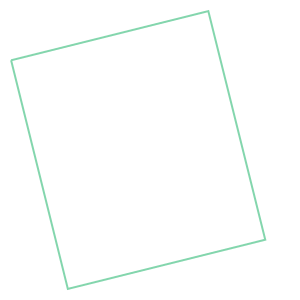

In [6]:
# read in the boundary polygon
boundary = gp.read_file(datapath / 'shp' / 'Model_domain.shp')

# create a polyline from the polygon
boundary_line =  LineString([Point(i) for i in boundary.iloc[0].geometry.exterior.coords])
boundary_line

In [7]:
# instersect the bounding polygon with the grid to get boundary cells
ix_boundary = ix.intersect(boundary_line.buffer(25, resolution=4))

In [8]:
ix_df = pd.DataFrame.from_records(ix_boundary)
ix_df.head()

,cellids,vertices,areas,ixshapes
0,"(0, 0)","[([(array([1516807.7649682]), array([5033525.9...",1818.572486,"POLYGON ((1516807.764968205 5033525.973979044,..."
1,"(0, 1)","[([(array([1516818.50671796]), array([5033564....",768.997804,"POLYGON ((1516818.506717961 5033564.332087163,..."
2,"(0, 2)","[([(array([1516867.02150427]), array([5033576....",768.997804,"POLYGON ((1516867.021504275 5033576.428181943,..."
3,"(0, 3)","[([(array([1516915.53629059]), array([5033588....",768.997804,"POLYGON ((1516915.536290589 5033588.524276723,..."
4,"(0, 4)","[([(array([1516964.0510769]), array([5033600.6...",768.997804,"POLYGON ((1516964.051076903 5033600.620371503,..."


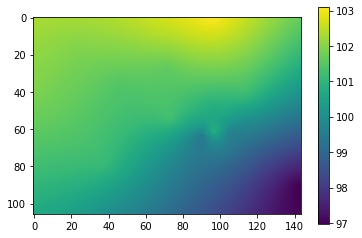

In [9]:
# read in the september 2019 measured heads to make the GHB data
sep19_head = fu.Raster.load(datapath / 'raster' / 'heads_sep2019.asc')
plt.imshow(sep19_head.get_array(1))
plt.colorbar()

In [10]:
# resample these heads to the model
head = sep19_head.resample_to_grid(m.modelgrid,band=sep19_head.bands[0], method="nearest")

In [11]:
# make the GHB stress period data
ghb_spd = []
for icpl in ix_boundary.cellids:
    cond = 100.0
    for layer in [0,2]:
        # note - structured grid so *icpl unpacks row/col
        ghb_spd.append([(layer, *icpl), head[icpl], cond, f'GHB{layer+1}'])
       

In [12]:
# create the package
ghb = fp.mf6.ModflowGwfghb(model=m, 
                                stress_period_data=ghb_spd, 
                                boundnames=True) 

In [13]:
m.write_input()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model sgn_50...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package oc...
    writing package sfr_0...
    writing package wel_0...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 708 based on size of stress_period_data
SFRmaker v. 0.post31.dev0+g191fdd7

Running Flopy v. 3.3.5 diagnostics...
passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking reach connections for proximity...
0 segments with non-adjacent reaches found.
At segments:


0 segments with non-adjacent reaches found.
At segments:



Checking for model cells with multiple non-zero SFR conduc

In [14]:
m

sgn_50 model version 0.post31.dev0+g191fdd7
3 layer(s), 96 row(s), 83 column(s)
delr: [50.00...50.00] meters
delc: [50.00...50.00] meters
CRS: EPSG:3003
length units: meters
xll: 1517927.496282395; yll: 5028909.73961192; rotation: 14.0
Bounds: (1516766.2711835166, 1521954.2235464402, 5028909.73961192, 5034571.134964784)
Packages: dis ic npf rcha_0 oc sfr_0 wel_0 ghb_0
1 period(s):
 per start_datetime        end_datetime     perlen  steady  nstp
   0     2021-01-01 2022-01-01 01:06:40 31540000.0    True     1
   ...
   0     2021-01-01 2022-01-01 01:06:40 31540000.0    True     1

In [15]:
m.dis.export('testgrid.shp')

wrote testgrid.shp


In [16]:
os.system('mf6')

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Jul 31 2021 20:33:12 with IFORT compiler (ver. 19.10.3)

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
use of the software.

 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/09/22 15:05:40
 
 Writing

0

In [17]:
top = m.dis.top.array

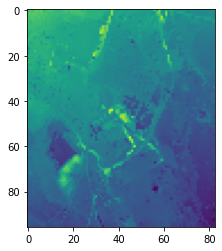

In [18]:
plt.imshow(top)

In [19]:
h = fu.binaryfile.HeadFile('../../models/sgn_mfsetup/sgn_50.hds').get_alldata()

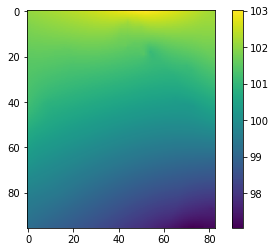

In [20]:
plt.imshow(np.squeeze(h)[0])
plt.colorbar()

### check flooding

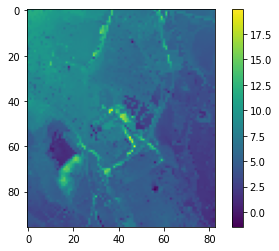

In [21]:
plt.imshow(top-np.squeeze(h)[0])
plt.colorbar()

In [22]:
df1,df2 = fu.Mf6ListBudget('../../models/sgn_mfsetup/sgn_50.list').get_dataframes()

In [23]:
df1

,WEL_IN,GHB_IN,RCH_IN,SFR_IN,TOTAL_IN,WEL_OUT,GHB_OUT,RCH_OUT,SFR_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1971-01-01 01:11:58.945312,0.1288,7.1802,0.067602,0.0,7.3766,0.7666,1.6211,0.0,4.9889,7.3766,-0.000021,-0.0


In [24]:
df2

,WEL_IN,GHB_IN,RCH_IN,SFR_IN,TOTAL_IN,WEL_OUT,GHB_OUT,RCH_OUT,SFR_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1971-01-01 01:11:58.945312,4062352.0,226463072.0,2132160.25,0.0,232657584.0,24178564.0,51130412.0,0.0,157349280.0,232658256.0,-668.346008,-0.0
